In [25]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path: sys.path.insert(0, project_root)

from src._utils import main_logger


In [26]:
import os
import numpy as np
import pandas as pd

import src.data_handling as data_handling

# paths
PRODUCTION_MODEL_FOLDER_PATH = 'models/production'
DFN_FILE_PATH = os.path.join(PRODUCTION_MODEL_FOLDER_PATH, 'dfn_best.pth')
GBM_FILE_PATH =  os.path.join(PRODUCTION_MODEL_FOLDER_PATH, 'gbm_best.pth')
EN_FILE_PATH = os.path.join(PRODUCTION_MODEL_FOLDER_PATH, 'en_best.pth')

PREPROCESSOR_PATH = 'preprocessors/column_transformer.pkl'

file_name = 'online_retail.csv'
file_path = os.path.join(project_root, 'data', 'raw', file_name)
df = pd.read_csv(file_path)
df = data_handling.scripts.sanitize_column_names(df=df)
df = data_handling.scripts.structure_missing_values(df=df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
 7   country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [27]:
#### stockcode
df['stockcode'] = df['stockcode'].replace('m', 'M')
stockcodes_to_drop = ['B', 'CRUK', 'C2']
df = df[~df['stockcode'].isin(stockcodes_to_drop)]

#### remove unnecessary features
if 'description' in df.columns.tolist(): df = df.drop(columns='description')


#### adds quantity momentum features
df['invoicedate'] = pd.to_datetime(df['invoicedate'], errors='coerce')
df['year'] = df['invoicedate'].dt.year
df['year_month'] = df['invoicedate'].dt.to_period('M')
df['month_name'] = df['invoicedate'].dt.strftime('%b')
df['day_of_week'] = df['invoicedate'].dt.strftime('%a')
# df['sales'] = df['quantity'] * df['unitprice']

### last month
_temp_df_prod_month_agg = df.copy().groupby(['stockcode', 'year_month']).agg(
    prod_total_monthly_quantity=('quantity', 'sum'),
    prod_ave_monthly_price=('unitprice', 'mean')
).reset_index().sort_values(by=['stockcode', 'year_month'])
_temp_df_prod_month_agg['product_avg_quantity_last_month'] = _temp_df_prod_month_agg.groupby('stockcode')['prod_total_monthly_quantity'].shift(1)
_temp_df_prod_last_month_agg = _temp_df_prod_month_agg.groupby('stockcode')['product_avg_quantity_last_month'].mean().reset_index()
df_fin = pd.merge(df, _temp_df_prod_last_month_agg, on='stockcode', how='left')
df_fin['product_avg_quantity_last_month'] = df_fin['product_avg_quantity_last_month'].fillna(value=0)


#### add unitprice related features
### vs max
_temp_df_max_price = df.groupby('stockcode')['unitprice'].max().reset_index()
_temp_df_max_price.rename(columns={'unitprice': 'product_max_price_all_time'}, inplace=True)
df_fin = pd.merge(left=df_fin, right=_temp_df_max_price, on='stockcode', how='left')

df_fin['unitprice_vs_max'] = df_fin['unitprice'] / df_fin['product_max_price_all_time']

### vs ave
df_fin['unitprice_to_avg'] = df_fin['unitprice'] / df_fin['product_avg_quantity_last_month']
df_fin.loc[df_fin['product_avg_quantity_last_month'] == 0, 'unitprice_to_avg'] = 0

### squared
df_fin['unitprice_squared'] = df_fin['unitprice'] ** 2

### log
df_fin['unitprice_log'] = np.log1p(df_fin['unitprice'])


####  add customer related features
df_fin['is_registered'] = np.where(df_fin['customerid'].isna(), 0, 1)
df_fin['customerid'] = df_fin['customerid'].fillna('unknown').astype('str')

# _df_cus = df_fin.groupby(['customerid', 'stockcode', 'year_month']).agg(
#     monthly_quantity=('quantity', 'sum'),
#     monthly_unique_invoices=('invoiceno', 'nunique'),
#     monthly_last_purchase_date=('invoicedate', 'max')
# ).reset_index()
# _df_cus['pfin_last_purchase_date_stockcode'] = _df_cus.groupby(['customerid', 'stockcode'])['monthly_last_purchase_date'].shift(1)
# _df_cus['invoice_timestamp_end'] = _df_cus['year_month'].dt.end_time
# _df_cus['customer_recency_days_by_stockcode'] = (
#     _df_cus['invoice_timestamp_end'] - _df_cus['pfin_last_purchase_date_stockcode']
# ).dt.days
# df_fin = df_fin.merge(
#     _df_cus[['customerid', 'stockcode', 'year_month', 'customer_recency_days_by_stockcode']],
#     on=['customerid', 'stockcode', 'year_month'],
#     how='left'
# )
# # imputation
# max_recency = df_fin['customer_recency_days_by_stockcode'].max()
# df_fin['customer_recency_days_by_stockcode'] = df_fin['customer_recency_days_by_stockcode'].fillna(value=max_recency + 30)
# df_fin['customer_recency_days_by_stockcode'] = df_fin['customer_recency_days_by_stockcode'].fillna(365)


# # spent 
# if not _df_cus['customerid'].isna().all():
#     _df_cus_prod_agg = _df_cus.groupby(['customerid', 'stockcode', 'year_month']).agg(
#         monthly_quantity=('monthly_quantity', 'sum'),
#         monthly_unique_invoices=('monthly_unique_invoices', 'sum')
#     ).reset_index()

#     # Sort by customer, stockcode, and date to ensure rolling window is chronological
#     _df_cus_prod_agg = _df_cus_prod_agg.sort_values(by=['customerid', 'stockcode', 'year_month'])

#     # Compute customer_total_spend_ltm and customer_freq_ltm
#     _df_cus_prod_agg['customer_total_spend_ltm_by_stockcode'] = _df_cus_prod_agg.groupby(['customerid', 'stockcode'])['monthly_quantity'].rolling(window=3, closed='left').sum().reset_index(level=[0, 1], drop=True)
#     _df_cus_prod_agg['customer_freq_ltm_by_stockcode'] = _df_cus_prod_agg.groupby(['customerid', 'stockcode'])['monthly_unique_invoices'].rolling(window=3, closed='left').sum().reset_index(level=[0, 1], drop=True)

#     # Merge the new features back into the main DataFrame
#     df_fin = pd.merge(
#         df_fin,
#         _df_cus_prod_agg[['customerid', 'stockcode', 'year_month', 'customer_total_spend_ltm_by_stockcode', 'customer_freq_ltm_by_stockcode']],
#         on=['customerid', 'stockcode', 'year_month'],
#         how='left'
#     )

#     # Fill NaN values with 0
#     df_fin['customer_total_spend_ltm_by_stockcode'] = df_fin['customer_total_spend_ltm_by_stockcode'].fillna(0)
#     df_fin['customer_freq_ltm_by_stockcode'] = df_fin['customer_freq_ltm_by_stockcode'].fillna(0)

# else:
#     df_fin['customer_freq_ltm_by_stockcode'] = 0
#     df_fin['customer_total_spend_ltm_by_stockcode'] = 0


# drop unnecessary data
stockcodes_to_drop = ['D', 'S']
df_fin = df_fin[~df_fin['stockcode'].isin(stockcodes_to_drop)]
df_fin = df_fin.drop(columns=['month_name'], axis='columns')


# quantity (drop negative vals)
df_fin['quantity'] = pd.to_numeric(df_fin['quantity'], errors='coerce')
df_fin['quantity'] = df_fin['quantity'].fillna(0)
df_fin = df_fin[df_fin['quantity'] > 0]


# dtype transformation
df_fin['year_month'] = df_fin['year_month'].dt.month
df_fin['invoicedate'] = df_fin['invoicedate'].astype(int) / 10 ** 9


# imputation
df_fin['customerid'] = df_fin['customerid'].fillna(value='unknown')
df_fin['stockcode'] = df_fin['stockcode'].fillna(value='unknown')
df_fin['invoiceno'] = df_fin['invoiceno'].fillna(value='unknown')
# df_fin['quantity'] = df_fin['quantity'].fillna(value=0)

# imputation (values referred to stockcode)
df_imputed = df_fin.copy().sort_values(by='stockcode').reset_index(drop=True)
df_stockcode = df_imputed.groupby('stockcode', as_index=False).agg(
    imputed_country=('country', lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown'),
    imputed_unitprice=('unitprice', 'median')
)
df_fin = pd.merge(df_fin, df_stockcode, on='stockcode', how='left')
df_fin['country'] = df_fin['country'].fillna(df_fin['imputed_country'])

global_median = df_fin['unitprice'].median()
df_fin['unitprice'] = df_fin['unitprice'].fillna(df_fin['imputed_unitprice'])
df_fin['unitprice'] = df_fin['unitprice'].fillna(global_median)
df_fin = df_fin.drop(columns=['imputed_country', 'imputed_unitprice'])

# df_fin['is_return'] = (df_fin['sales'] < 0).astype(int)
# drop negative sales (return etc)
# df_fin_log = df_fin.copy()
# df_fin_log = df_fin_log[df_fin_log['sales'] > 0]
# df_fin_log['sales'] = np.where(df_fin_log['is_return'] == 1, 0, df_fin_log['sales'])

# transform sales to logged values
alpha = 1e-10
df_fin['quantity'] = np.log1p(df_fin['quantity'] + alpha)

main_logger.info(df_fin.info())

2025-08-17 00:06:25,192 - root - INFO - None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531138 entries, 0 to 531137
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   invoiceno                        531138 non-null  object 
 1   stockcode                        531138 non-null  object 
 2   quantity                         531138 non-null  float64
 3   invoicedate                      531138 non-null  float64
 4   unitprice                        531138 non-null  float64
 5   customerid                       531138 non-null  object 
 6   country                          531138 non-null  object 
 7   year                             531138 non-null  int32  
 8   year_month                       531138 non-null  int64  
 9   day_of_week                      531138 non-null  object 
 10  product_avg_quantity_last_month  531138 non-null  float64
 11  product_max_price_all_time       531138 non-null  float64
 12  un

In [28]:
df = df_fin.copy()

In [29]:
from sklearn.model_selection import train_test_split

import src.model.torch_model as t


# classify num and cat columns
target_col = 'quantity'

num_cols, cat_cols = data_handling.scripts.categorize_num_cat_cols(df=df, target_col=target_col)
if cat_cols: 
    for col in cat_cols: df[col] = df[col].astype('string')


# # creates train, val, test datasets
# y = df[target_col]
# X = df.copy().drop(target_col, axis='columns')

# test_size, random_state = 50000, 42
# X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=test_size, random_state=random_state)

# from sklearn.model_selection import train_test_split
# from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from category_encoders import BinaryEncoder


# num_transformer = Pipeline(steps=[
#     # ('imputer', KNNImputer()), 
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
#     ])
# cat_transformer = Pipeline(steps=[
#     # ('imputer', SimpleImputer(strategy='most_frequent', fill_value='unknown')),
#     ('encoder', BinaryEncoder(cols=cat_cols))
# ])
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, num_cols),
#         ('cat', cat_transformer, cat_cols)
#     ],
#     remainder='passthrough'
# )

# X_train_processed = preprocessor.fit_transform(X_train)
# X_val_processed = preprocessor.transform(X_val)
# X_test_processed = preprocessor.transform(X_test)

# main_logger.info(f'transformed input datasets: X_train: {X_train_processed.shape}, X_val: {X_val_processed.shape}, X_test: {X_test_processed.shape}')


In [30]:
import torch
import joblib

stockcode = '85123A'
random_state = 42
PREPROCESSOR_PATH = os.path.join(project_root, 'preprocessors/column_transformer.pkl')
preprocessor = joblib.load(PREPROCESSOR_PATH)

df_stockcode = df[df['stockcode'] == stockcode]
X_stockcode = df_stockcode.copy().drop(columns=target_col)
y_stockcode = df_stockcode.copy()[target_col]

X_tv, X_test_stockcode, y_tv, y_test_stockcode = train_test_split(X_stockcode, y_stockcode, test_size=500, random_state=random_state)
X_train_stockcode, X_val_stockcode, y_train_stockcode, y_val_stockcode = train_test_split(X_tv, y_tv, test_size=500, random_state=random_state)

X_train_stockcode = preprocessor.transform(X_train_stockcode)
X_val_stockcode = preprocessor.transform(X_val_stockcode)

batch_size = 32
train_data_loader_stockcode = t.scripts.create_torch_data_loader(X=X_train_stockcode, y=y_train_stockcode, batch_size=batch_size)
val_data_loader_stockcode = t.scripts.create_torch_data_loader(X=X_val_stockcode, y=y_val_stockcode, batch_size=batch_size)

file_path = os.path.join(project_root, 'models/production/dfn_best.pth')
model = t.scripts.load_model(input_dim=X_train_stockcode.shape[1], file_path=file_path)

# retrain the best model
model, _ = t.scripts.train_model(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.MSELoss(),
    num_epochs=1000,
    min_delta=0.00001,
    patience=10,
    train_data_loader=train_data_loader_stockcode,
    val_data_loader=val_data_loader_stockcode,
    device_type='cpu'
)

/opt/anaconda3/envs/new_tf_env/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/new_tf_env/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/new_tf_env/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.1 when usin

In [31]:
DFN_FILE_PATH_OVERALL_BEST = os.path.join(PRODUCTION_MODEL_FOLDER_PATH, 'dfn_best.pth')
DFN_FILE_PATH_STOCKCODE = os.path.join(PRODUCTION_MODEL_FOLDER_PATH, f'dfn_best_{stockcode}.pth')
PREPROCESSOR_PATH = os.path.join(project_root, 'preprocessors/column_transformer.pkl')

# preprocessor (trained on data)
preprocessor = joblib.load(PREPROCESSOR_PATH)


df_stockcode = df[df['stockcode'] == stockcode]

target_col = 'quantity'
X_stockcode = df_stockcode.copy().drop(columns=target_col)
y_stockcode = df_stockcode.copy()[target_col]

test_size, random_state = int(min(len(X_stockcode) * 0.3, 500)), 42  # type: ignore
X_tv, X_test_stockcode, y_tv, y_test_stockcode = train_test_split(X_stockcode, y_stockcode, test_size=test_size, random_state=random_state)
X_train_stockcode, X_val_stockcode, y_train_stockcode, y_val_stockcode = train_test_split(X_tv, y_tv, test_size=test_size, random_state=random_state)

X_train_stockcode = preprocessor.transform(X_train_stockcode)
X_val_stockcode = preprocessor.transform(X_val_stockcode)

batch_size = 32
train_data_loader_stockcode = t.scripts.create_torch_data_loader(X=X_train_stockcode, y=y_train_stockcode, batch_size=batch_size)
val_data_loader_stockcode = t.scripts.create_torch_data_loader(X=X_val_stockcode, y=y_val_stockcode, batch_size=batch_size)

file_path = os.path.join(project_root, 'models/production/dfn_best.pth')
model = t.scripts.load_model(input_dim=X_train_stockcode.shape[1], file_path=file_path)

# retrain the best model
model, _ = t.scripts.train_model(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.MSELoss(),
    num_epochs=1000,
    min_delta=0.00001,
    patience=10,
    train_data_loader=train_data_loader_stockcode,
    val_data_loader=val_data_loader_stockcode,
    device_type='cpu'
)

/opt/anaconda3/envs/new_tf_env/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/new_tf_env/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/new_tf_env/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.1 when usin

In [32]:
import pandas as pd
import joblib

from src._utils import main_logger, s3_load
import src.model.torch_model as t

X_TEST_PATH = os.environ.get('X_TEST','data/x_test_df.parquet')

stockcode = '85123A'

# df = df_fin.copy()
# df_stockcode = df[df['stockcode'] == stockcode]

# file_path = os.path.join(project_root, 'models', 'production', f'dfn_best_{stockcode}.pth')
# model = t.scripts.load_model(input_dim=65, file_path=file_path)

x_test_io = s3_load(file_path=X_TEST_PATH)
X_test = pd.read_parquet(x_test_io) if x_test_io is not None else None



if X_test is not None:
    min_price = 2
    max_price = 100
    NUM_PRICE_BINS = 100
    price_range = np.linspace(min_price, max_price, num=NUM_PRICE_BINS)
    price_range_df = pd.DataFrame({ 'unitprice': price_range })

    test_sample = X_test.sample(n=5000, random_state=42) 
    test_sample_merged = test_sample.merge(price_range_df, how='cross')
    test_sample_merged.drop('unitprice_x', axis=1, inplace=True)
    test_sample_merged.rename(columns={'unitprice_y': 'unitprice'}, inplace=True)

    X = preprocessor.transform(test_sample_merged) if preprocessor else test_sample_merged

    model.eval()
    input_tensor = torch.tensor(X, dtype=torch.float32, device=torch.device('cpu'))
    epsilon = 0
    with torch.inference_mode():
        y_pred = model(input_tensor)
        y_pred = y_pred.cpu().numpy().flatten()
        y_pred_actual = np.exp(y_pred + epsilon)
        main_logger.info(f"primary model's prediction for stockcode {stockcode} - actual quantity {y_pred_actual[0: 10]}")


    df_ = test_sample_merged.copy()
    df_['quantity'] = np.floor(y_pred_actual * 10)
    df_['sales'] = df_['quantity'] * df_['unitprice']
    df_ = df_.sort_values(by='unitprice')

    df_results = df_.groupby('unitprice').agg(
        quantity=('quantity', 'mean'),
        quantity_min=('quantity', 'min'),
        quantity_max=('quantity', 'max'),
        sales=('sales', 'mean'),
    ).reset_index()

    optimal_row = df_results.loc[df_results['sales'].idxmax()]
    optimal_price = optimal_row['unitprice']
    optimal_quantity = optimal_row['quantity']
    best_sales = optimal_row['sales']

    all_outputs = []
    for _, row in df_results.iterrows():
        current_output = {
            "stockcode": stockcode,
            "unit_price": float(row['unitprice']),
            'quantity': int(row['quantity']),
            'quantity_min': int(row['quantity_min']),
            'quantity_max': int(row['quantity_max']),
            "predicted_sales": float(row['sales']),
            "optimal_unit_price": float(optimal_price), # type: ignore
            "max_predicted_sales": float(best_sales), # type: ignore
        }
        all_outputs.append(current_output)

    main_logger.info(f'optimal price: $ {optimal_price:,.2f}, quantity: {optimal_quantity:,}, maximum sales: $ {best_sales:,.2f}')


2025-08-17 00:06:30,187 - root - INFO - primary model's prediction for stockcode 85123A - actual quantity [218.861   206.6493  195.1191  184.23213 173.95262 164.2466  155.0822
 146.4291  138.26419 130.62407]
2025-08-17 00:06:30,334 - root - INFO - optimal price: $ 16.85, quantity: 38,262.0078125, maximum sales: $ 644,656.86


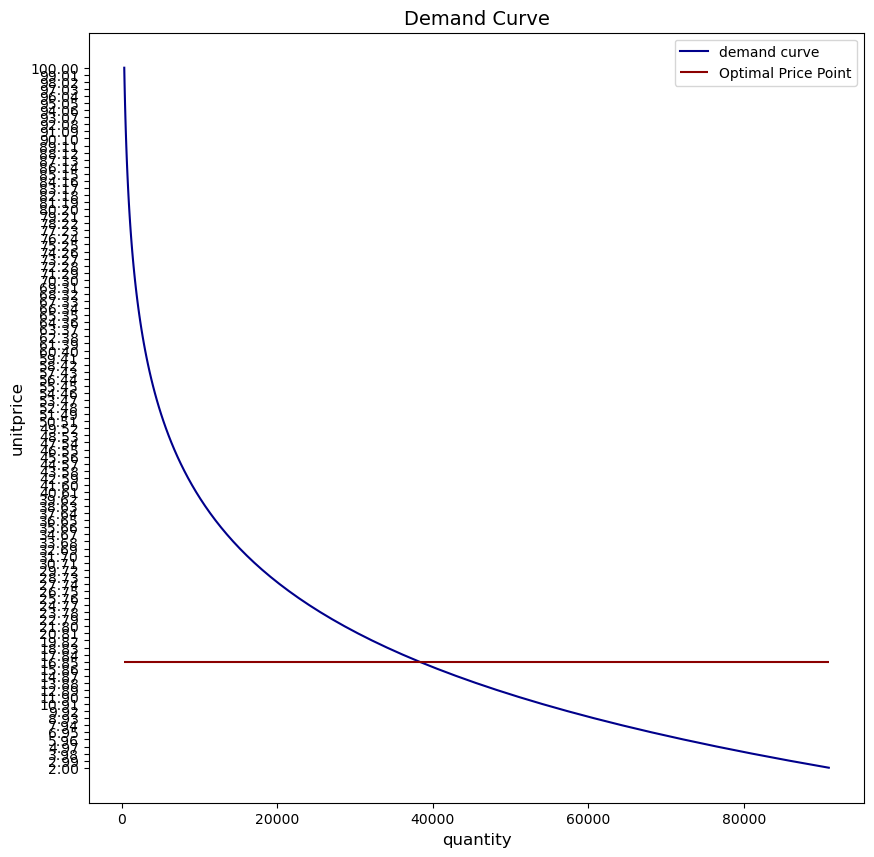

In [ ]:
# demand curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.plot(df_results['quantity'], df_results['unitprice'], color='darkblue', label='demand curve')

# Highlight the optimal price point on the graph
plt.hlines(y=optimal_price, xmin=min(df_results['quantity']), xmax=max(df_results['quantity']), color='darkred', zorder=5, label='Optimal Price Point')

# Add labels and a title for clarity
plt.xlabel('quantity', fontsize=12)
plt.ylabel('unitprice', fontsize=12)
plt.title('Demand Curve', fontsize=14)
plt.legend()
plt.yticks(df_results['unitprice']) # Ensure all price points are shown on the y-axis

plt.show()

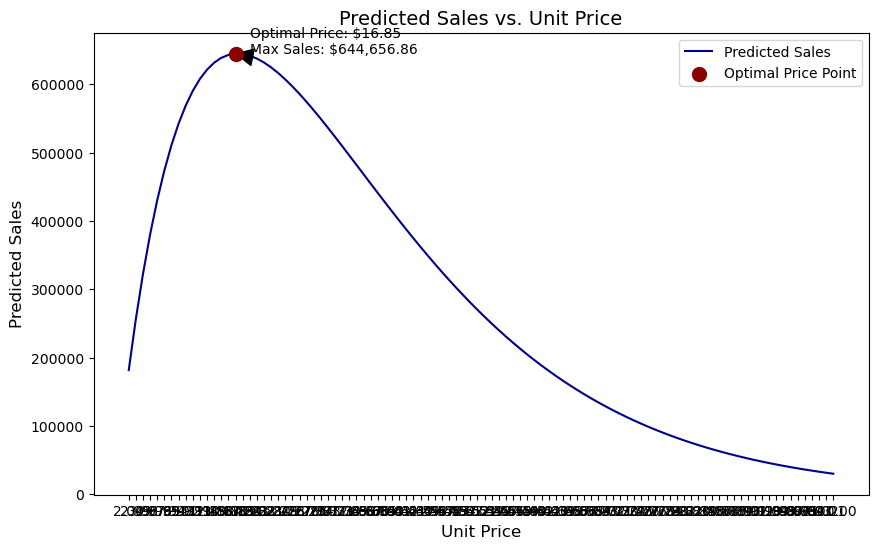

In [34]:
# sales
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# x_plt = df_['unitprice'][df_.index % 100 == 0]
# y_plt = df_['sales'][df_.index % 100 == 0]

plt.plot(df_results['unitprice'], df_results['sales'], color='darkblue', label='Predicted Sales')

# Highlight the optimal price point on the graph
plt.scatter(optimal_price, best_sales, color='darkred', s=100, zorder=5, label='Optimal Price Point')

# Add labels and a title for clarity
plt.xlabel('Unit Price', fontsize=12)
plt.ylabel('Predicted Sales', fontsize=12)
plt.title('Predicted Sales vs. Unit Price', fontsize=14)
plt.legend()

plt.xticks(df_results['unitprice']) # Ensure all price points are shown on the x-axis

# Annotate the optimal point with its values
plt.annotate(
    f'Optimal Price: ${optimal_price:,.2f}\nMax Sales: ${best_sales:,.2f}',
    xy=(optimal_price, best_sales),
    xytext=(optimal_price + 2, best_sales + 10),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=10
)
# plt.savefig('my_plot.png')
plt.show()